In [ ]:
Optimisation des prix 

In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn gym

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------------------------------- 721.7/721.7 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827738 sha256=cf6a35eee536905f2c22140da867f11541de63e79983ff163f7697e23238fd3d
  Stored in directory: c:\users\mariem\appdata\local\pip\cache\wheels\95\51\6c\9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
Note: you may need to restart the kernel to use updated packages.

Données chargées avec succès. Dimensions: (1000, 11)
Exemple de données:
   Fact_ID  Full_Date  Month  Year        ProductName   Category  \
0      375 2024-10-21     10  2024       Hair Serum 1   Haircare   
1       28 2023-04-13      4  2023  Eau de Toilette 5  Fragrance   
2      261 2022-08-20      8  2022        Face Wash 6   Skincare   
3      806 2023-10-25     10  2023        Face Wash 6   Skincare   
4      606 2024-11-17     11  2024            Blush 7     Makeup   

                   Brandname              shopname  Quantite  \
0               walker group  cosmetiques radiance         7   
1  anthony colon and jimenez  cosmetiques radiance        11   
2  brown townsend and dalton  cosmetiques radiance        17   
3  brown townsend and dalton          eclat studio         5   
4    gibbs medina and carter       beaute elegante        14   

   Prix_Unitaire_TND_1  Season  
0           140.300003       4  
1           102.370003       2  
2           144.600006       3  
3

C:\Users\Mariem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 10/50, Reward: 497374.97, Epsilon: 0.95
Episode 20/50, Reward: 495229.96, Epsilon: 0.90
Episode 30/50, Reward: 493208.12, Epsilon: 0.86
Episode 40/50, Reward: 512363.61, Epsilon: 0.82
Episode 50/50, Reward: 487211.10, Epsilon: 0.78


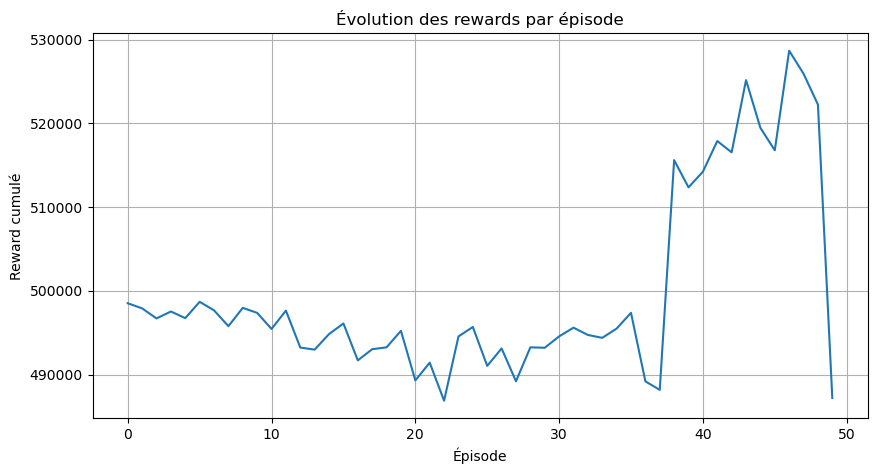


Génération des recommandations...

Exemple de recommandations :
          product                  shop  current_price  \
0       Blush 538          eclat studio     160.630005   
1    Body Mist 72       beaute elegante      15.020000   
2  Body Scrub 252       beaute elegante      85.099998   
3   Body Wash 487  cosmetiques radiance      30.309999   
4   Body Wash 691          eclat studio      83.300003   

            recommendation  
0    Garder le prix actuel  
1  Augmenter le prix de 5%  
2  Augmenter le prix de 5%  
3  Augmenter le prix de 5%  
4    Garder le prix actuel  

Recommandations sauvegardées dans 'recommandations_prix.csv'


In [11]:
###### import pandas as pd
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# 1. Chargement des données depuis SQL
def load_data():
    server = 'DESKTOP-OQ959SK'
    database = 'FinalDW'
    conn_str = f'mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
    engine = create_engine(conn_str)

    query = """
    SELECT
        fs.Fact_ID,
        dd.Full_Date,
        dd.Month,
        dd.Year,
        dp.ProductName,
        dc.Category,
        db.Brandname,
        ds.shopname,
        fs.Quantite,
        fs.Prix_Unitaire_TND_1
    FROM
        Fact_Sales fs
    INNER JOIN Dim_Date dd ON fs.Date_FK = dd.Date_PK
    INNER JOIN Dim_Product dp ON fs.Product_PK = dp.Product_PK
    INNER JOIN Dim_Category dc ON dp.Category_FK = dc.Category_PK
    INNER JOIN Dim_Brand db ON dp.Brand_FK = db.Brand_PK
    INNER JOIN Dim_Shop ds ON fs.Shop_PK = ds.Shop_PK
    """
    
    df = pd.read_sql(query, engine)
    
    # Vérification des colonnes nécessaires
    required_columns = ['ProductName', 'shopname', 'Category', 'Brandname', 
                       'Prix_Unitaire_TND_1', 'Quantite', 'Month', 'Year']
    
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante: {col}")
    
    # Conversion des types pour assurer la compatibilité
    df['Prix_Unitaire_TND_1'] = pd.to_numeric(df['Prix_Unitaire_TND_1'])
    df['Quantite'] = pd.to_numeric(df['Quantite'])
    df['Month'] = pd.to_numeric(df['Month']).astype(int)
    df['Year'] = pd.to_numeric(df['Year']).astype(int)
    
    # Ajout de features supplémentaires
    df['Season'] = df['Month'].apply(lambda x: (x % 12 + 3) // 3)  # 1=Winter, 2=Spring, etc.
    
    return df

# 2. Environnement de Reinforcement Learning
class PricingEnv:
    def __init__(self, data):
        self.data = data
        # Création des paires uniques produit-magasin
        self.product_shops = data.groupby(['ProductName', 'shopname']).first().reset_index()[['ProductName', 'shopname', 'Category', 'Brandname']].values
        self.current_idx = 0
        self.n_products = len(self.product_shops)
        
        # Normalisation
        self.price_min = data['Prix_Unitaire_TND_1'].min()
        self.price_max = data['Prix_Unitaire_TND_1'].max()
        self.qty_min = data['Quantite'].min()
        self.qty_max = data['Quantite'].max()
        self.state_size = 6  # Nous avons 6 features dans l'état
    
    def reset(self):
        self.current_idx = 0
        state = self._get_state(self.current_idx)
        return np.reshape(state, [1, self.state_size])
    
    def _get_state(self, idx):
        product, shop, category, brand = self.product_shops[idx]
        product_data = self.data[(self.data['ProductName'] == product) & 
                               (self.data['shopname'] == shop)].iloc[0]
        
        # Normalisation des features
        normalized_price = (product_data['Prix_Unitaire_TND_1'] - self.price_min) / (self.price_max - self.price_min)
        normalized_qty = (product_data['Quantite'] - self.qty_min) / (self.qty_max - self.qty_min)
        normalized_month = product_data['Month'] / 12
        normalized_season = product_data['Season'] / 4
        
        # Encodage des catégories/marques (simplifié)
        category_encoded = hash(category) % 10 / 10
        brand_encoded = hash(brand) % 10 / 10
        
        return np.array([
            normalized_price,
            normalized_qty,
            normalized_month,
            normalized_season,
            category_encoded,
            brand_encoded
        ], dtype=np.float32)
    
    def step(self, action):
        product, shop, _, _ = self.product_shops[self.current_idx]
        product_data = self.data[(self.data['ProductName'] == product) & 
                               (self.data['shopname'] == shop)].iloc[0]
        
        current_price = product_data['Prix_Unitaire_TND_1']
        current_qty = product_data['Quantite']
        
        # Application de l'action
        if action == 0:  # Garder prix
            new_price = current_price
            promo = 0
        elif action == 1:  # Baisser 5%
            new_price = current_price * 0.95
            promo = 0
        elif action == 2:  # Augmenter 5%
            new_price = current_price * 1.05
            promo = 0
        else:  # Promotion 10%
            new_price = current_price * 0.90
            promo = 1
        
        # Modèle d'élasticité prix
        base_elasticity = -2.0
        category_factor = 1.2 if product_data['Category'] == 'Luxury' else 0.8
        season_factor = 1.1 if product_data['Season'] == 4 else 1.0
        
        price_change = (new_price - current_price) / current_price
        qty_change = base_elasticity * price_change * category_factor * season_factor
        
        if promo:
            qty_change += 0.3
        
        new_qty = max(current_qty * (1 + qty_change), 0.1)
        
        # Calcul du reward
        cost = new_price * 0.6
        margin = (new_price - cost) * new_qty
        change_penalty = 0.1 * abs(price_change) if action != 0 else 0
        reward = margin - change_penalty
        
        # Passage au produit suivant
        self.current_idx = (self.current_idx + 1) % self.n_products
        done = self.current_idx == 0
        
        next_state = self._get_state(self.current_idx) if not done else None
        if next_state is not None:
            next_state = np.reshape(next_state, [1, self.state_size])
        
        info = {
            'product': product,
            'shop': shop,
            'old_price': current_price,
            'new_price': new_price,
            'old_qty': current_qty,
            'new_qty': new_qty,
            'action': action
        }
        
        return next_state, reward, done, info

# 3. Agent Deep Q-Network
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, name):
        self.model.save_weights(name)
    
    def load(self, name):
        self.model.load_weights(name)

# 4. Fonction d'entraînement
def train_agent(env, agent, episodes=50, batch_size=32):
    rewards_history = []
    
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        rewards_history.append(total_reward)
        
        if (e + 1) % 10 == 0:
            print(f"Episode {e + 1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    
    return rewards_history

def generate_recommendations(env, agent, month, year):
    recommendations = []
    
    for idx in range(len(env.product_shops)):
        product, shop, _, _ = env.product_shops[idx]
        product_data = env.data[(env.data['ProductName'] == product) & 
                                (env.data['shopname'] == shop) &
                                (env.data['Month'] == month) &
                                (env.data['Year'] == year)]
        
        if len(product_data) > 0:
            state = env._get_state(idx)
            state = np.reshape(state, [1, env.state_size])
            action = agent.act(state)
            
            current_price = product_data['Prix_Unitaire_TND_1'].values[0]
            
            if action == 0:
                recommendation = "Garder le prix actuel"
            elif action == 1:
                recommendation = "Baisser le prix de 5%"
            elif action == 2:
                recommendation = "Augmenter le prix de 5%"
            else:
                recommendation = "Appliquer une promotion de 10%"
            
            recommendations.append({
                'product': product,
                'shop': shop,
                'current_price': current_price,
                'recommendation': recommendation
            })
    
    return pd.DataFrame(recommendations)




# 6. Pipeline principal
def main():
    # Chargement des données
    try:
        df = load_data()
        print("Données chargées avec succès. Dimensions:", df.shape)
        print("Exemple de données:")
        print(df.head())
    except Exception as e:
        print("Erreur lors du chargement des données:", str(e))
        return
    
    # Initialisation environnement
    try:
        env = PricingEnv(df)
        print(f"Environnement initialisé avec {len(env.product_shops)} produits-magasins")
    except Exception as e:
        print("Erreur lors de l'initialisation de l'environnement:", str(e))
        return
    
    # Initialisation agent
    try:
        agent = DQNAgent(env.state_size, action_size=4)
        print("Agent DQN initialisé avec succès")
    except Exception as e:
        print("Erreur lors de l'initialisation de l'agent:", str(e))
        return
    
    # Entraînement
    print("\nDébut de l'entraînement...")
    try:
        rewards_history = train_agent(env, agent, episodes=50)
        
        # Visualisation des résultats
        plt.figure(figsize=(10, 5))
        plt.plot(rewards_history)
        plt.title("Évolution des rewards par épisode")
        plt.xlabel("Épisode")
        plt.ylabel("Reward cumulé")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Erreur pendant l'entraînement:", str(e))
        return
    
    # Génération des recommandations
    print("\nGénération des recommandations...")
    try:
        recommendations = generate_recommendations(env, agent, month=10, year=2024)
        print("\nExemple de recommandations :")
        print(recommendations.head())
        
        # Sauvegarde des résultats
        recommendations.to_csv('recommandations_prix.csv', index=False)
        print("\nRecommandations sauvegardées dans 'recommandations_prix.csv'")
    except Exception as e:
        print("Erreur lors de la génération des recommandations:", str(e))
        return

if __name__ == "__main__":
    main()